In [1]:
%run ../ModelFactory.py --config /home/navidkrad/work/i3kiss/configs/config.yml --model_name gen2L3_loss --interactive


2024-05-08 04:22:36.457737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/navidkrad/work/i3kiss/utils/__init__.py:1: UserWarning: The recommended fonts to use plothist were not found. You can install them by typing 'install_latin_modern_fonts' in your terminal. 

  from utils.plotting_utils import *



Loading config file: /home/navidkrad/work/i3kiss/configs/config.yml

====== Updating config with extra args:
{'model_name': 'gen2L3_loss', 'features': ['log_rho', 'log_z', 'log_length', 'log_energy', 'interaction_height', 'cos_zenith', 'pdg_map', 'depth', 'cos_theta', 'multiplicity', 'mu_log_energy_max', 'mu_log_energy_mean', 'mu_log_energy_std', 'mu_radius_mean', 'singleness', 'mu_leading_energy_fraction', 'mu_bundle_log_energy']}
config:
{'batch_size': 8192,
 'class_weight': {},
 'clip_norm': 0.01,
 'clipnorm': 1.0,
 'dropout': 0.8,
 'ema_momentum': 0.999,
 'ema_overwrite_frequency': True,
 'features': ['log_rho',
              'log_z',
              'log_length',
              'log_energy',
              'interaction_height',
              'cos_zenith',
              'pdg_map',
              'depth',
              'cos_theta',
              'multiplicity',
              'mu_log_energy_max',
              'mu_log_energy_mean',
              'mu_log_energy_std',
              'mu_rad

In [2]:
"""
    Load DF
"""

import glob
base_dir = "/data/user/navidkrad/hdf/cascades_v0.1_L3/sim/IceCube/2020/CORSIKA-in-ice/20904/"
run_dirs = utils.natural_sort(glob.glob(f"{base_dir}/*/Level3/"))
run_dirs

level3_only_files = []

for run_dir in run_dirs:
    run_range = run_dir.split("/")[-3]
    fname = f"{base_dir}/{run_range}/Level3/Level3_{run_range}.hdf"
    #print(fname)
    #assert False
    if not os.path.isfile(fname):
        continue
    level3_only_files.append(fname)
    print(run_range)

df_pos = pd.concat([pd.read_hdf(f) for f in level3_only_files])

df_neg = pd.read_hdf("/data/user/navidkrad/hdf/cascades_v0.1_L3/sim/IceCube/2020/CORSIKA-in-ice/20904/0000000-0000999/combined_preproc/combined_preproc_0000000-0000999_01_of_50.hdf5").query("Level3==0")
df = pd.concat([df_neg.sample(len(df_pos)), df_pos]).sample(frac=1)
df["Level3"].value_counts()


0000000-0000999
0001000-0001999
0002000-0002999
0003000-0003999
0004000-0004999
0005000-0005999
0006000-0006999
0007000-0007999


Level3
0.0    66145
1.0    66145
Name: count, dtype: int64

In [10]:
class_weights = tf_utils.get_class_weights(df['Level3'])
class_weights

NameError: name 'tf_utisl' is not defined

0.1
0.12589254117941673


0.15848931924611137
0.19952623149688797
0.251188643150958
0.31622776601683794
0.3981071705534973
0.5011872336272724
0.6309573444801934
0.7943282347242816
1.0


Text(0.5, 0, 'pseudo score')

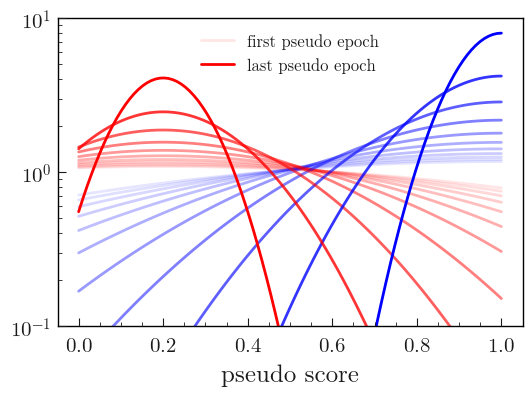

In [3]:
"""
    create a "fake prediction" based on truth info
"""


label = mf.labels[0]
df['truth'] = df[label].astype('bool')
truth = df.truth


from scipy.stats import truncnorm
x = np.linspace(0,1)


beta  = 0.5
m     = 10
loc   = 1
scale = 1


def truncnorm_wrapper(a_trunc, b_trunc, loc, scale):
    a, b = (a_trunc - loc) / scale, (b_trunc - loc) / scale
    return truncnorm(a, b, loc, scale)

x = np.linspace(0,1,100)


fig, ax = plt.subplots()

scales = np.linspace(1, 0.1, 11)


pred_names = []

alphas = np.logspace(0, 1, len(scales))/10


for iscale, scale in enumerate(scales):
    if scale == scales[0]:
        label = 'first pseudo epoch'
    elif scale == scales[-1]:
        label = 'last pseudo epoch'
    else:
        label = None

    pdf_pos = truncnorm_wrapper(0, 1, loc=1,   scale=scale)
    pdf_neg = truncnorm_wrapper(0, 1, loc=0.2, scale=scale)
    
    pred_name = 'pred%s'%scale    
    new_pred = pd.Series(index=df.index, dtype=float)    
    new_pred.loc[truth]  = pdf_pos.rvs(sum(truth))
    new_pred.loc[~truth] = pdf_neg.rvs(sum(~truth))
    df[pred_name] = new_pred
    
    alpha = alphas[iscale]
    print(alpha)
    ax.plot(x, pdf_pos.pdf(x),
           'b-', lw=2, alpha=alpha, )
    ax.plot(x, pdf_neg.pdf(x),
           'r-', lw=2, alpha=alpha, label=label )
    pred_names.append(pred_name)

df['all_ones'] = 1.0
df['all_zeros'] = 0.0
df['all_half'] = 0.5
pred_names_same = ['all_ones', 'all_zeros', 'all_half']
#pred_names.extend()
ax.legend()

ax.set_ylim(1E-1,10)
ax.set_yscale('log')
ax.set_xlabel('pseudo score')



In [4]:
df["Level3"].value_counts()/len(df) * 100



Level3
0.0    50.0
1.0    50.0
Name: count, dtype: float64

In [5]:
"""

definite loss functions

"""

def tf_effective_number(y, eps=1e-9):
    # Assuming y_pred are the classification scores p_i
    # Calculate weights w_i = 1/p_i, adding a small epsilon to avoid division by zero
    weights = 1 / (y+eps)

    # Calculate the sum of weights and the sum of squared weights
    sum_weights = tf.reduce_sum(weights)
    sum_sq_weights = tf.reduce_sum(tf.square(weights))

    # Calculate N_eff
    N_eff = (sum_weights ** 2) / sum_sq_weights

    return N_eff


def tf_loss_n_accpetpos_over_n_accept(y_true, y_pred):
    """
        ratio of the number of positive accepted events to the 
        number of accepted events. 
        We want to be as close to 1 as possible, so we subtract 1 from this.
    """
    # batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
    y_pred_pos = y_pred[y_true==1]
    
    # average number of accepted events
    n_accept = tf.reduce_sum(y_pred)

    # number of passed events
    n_passed = tf.reduce_sum(y_pred_pos)

    loss = 1 - n_passed/n_accept
    # print('--- DEBUG EPOCH VAR', tf.cast(epoch_var, tf.float32))
    #loss /= batch_size
    return loss

def tf_loss_n_eff_over_n_accept(y_true, y_pred):
    """ 
        ratio of the effective number of positive events to the 
        number of accepted events.

    """
    #batch_size = tf.cast(tf.shape(y_true)[0], tf.float64)

    y_pred_pos = y_pred[y_true==1]
    
    n_eff_pos = tf_effective_number(y_pred_pos)
    n_accepted = tf.reduce_sum(y_pred)
    #n_accepted = tf_effective_number(y_pred)
    

    # n_simulated = tf.reduce_sum(y_pred)
    # n_passed = tf.reduce_sum(y_pred_pos)
    loss = 1 - n_eff_pos/n_accepted

#     print(
# f""" 
#     {n_eff_pos = }
#     {n_accepted = }
#     {n_eff_pos/n_accepted = }
#     {loss = }
# """)
    return loss
    #return loss

def tf_loss_n_eff(y_true, y_pred):
    n_eff = tf_effective_number(y_pred)
    loss = n_eff
    return (1.0/loss)

def tf_loss_n_eff_pos(y_true, y_pred):
    # batch_size = tf.cast(tf.shape(y_true)[0], tf.float64)
    # mask_passed = np.random.random(size=int(batch_size)) < y_pred
    y_pred_pos = y_pred[y_true==1]
    n_eff_pos = tf_effective_number(y_pred_pos)

    loss = n_eff_pos
    return (1.0/loss)

def tf_loss_n_eff_pos(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_true)[0], tf.float64)
    mask_passed = np.random.random(size=int(batch_size)) < y_pred
    y_pred_pos = y_pred[(y_true==1) & mask_passed]
    n_eff_pos = tf_effective_number(y_pred_pos)

    loss = n_eff_pos
    return (1.0/loss)


def tf_loss_s(y_true, y_pred):
    y_pred_pos = y_pred[y_true==1]
    eps = 1e-5
    w = 1.0/(y_pred+eps) 
    N = len(y_pred) + eps
    yld = tf.reduce_sum(w)

    loss = N/np.sqrt(yld)
    return loss

def tf_loss_n_eff_pos_over_n_eff(y_true, y_pred):
    y_pred_pos = y_pred[y_true==1]
    n_eff_pos = tf_effective_number(y_pred_pos)
    n_eff = tf_effective_number(y_pred)
    loss = 1-n_eff_pos/n_eff
    return loss


epoch_var = tf.Variable(0, trainable=False, dtype=tf.int32)
class EpochVariableUpdater(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_train_begin(self, logs=None):
        # Set the epoch variable to zero at the beginning of training
        tf.keras.backend.set_value(epoch_var, 0)

    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.set_value(epoch_var, epoch + 1)
        print('DEBUG', epoch, epoch_var)




def tf_rel_uncert(y, eps=1e-9):
    weights = 1 / (y+eps)

    sum_weights = tf.reduce_sum(weights)
    sum_sq_weights = tf.reduce_sum(tf.square(weights))
    sqrt_sum_sq_weights = tf.sqrt(sum_sq_weights)

    rel_unc = sqrt_sum_sq_weights / (sum_weights)
    return rel_unc

def tf_rel_uncert_loss(y_true, y_pred):

    y_pred_pos = y_pred[y_true==1]
    y_pred_neg  = y_pred[y_true==0]

    rel_uncert_pos = tf_rel_uncert(y_pred_pos)
    rel_uncert_neg = tf_rel_uncert(y_pred_neg)

    return rel_uncert_pos

def tf_rel_uncert_neg_loss(y_true, y_pred):

    y_pred_pos = y_pred[y_true==1]
    y_pred_neg  = y_pred[y_true==0]

    rel_uncert_pos = tf_rel_uncert(y_pred_pos)
    rel_uncert_neg = tf_rel_uncert(y_pred_neg)

    return rel_uncert_pos/rel_uncert_neg







bce = tf.keras.losses.BinaryCrossentropy()
bfce = tf.keras.losses.BinaryFocalCrossentropy()


models_info = {
        #'f1score':dict(loss=f1score),
        #'n_eff_over_n_accpt_number': dict(loss=tf_loss_n_eff_over_n_accpt),
        #'n_accepted_over_n_sim': dict(loss=tf_loss_n_passed_over_n_accept),

        'nominal': dict(label='Binary Cross Entropy'),    
        'n_eff_over_n_accpt_number':   dict(loss=tf_loss_n_eff_over_n_accept, label="$1-N_{eff}^{positive}/N_{accpt}$"),
        'n_accpt_over_n_accpt_number': dict(loss=tf_loss_n_accpetpos_over_n_accept, label="$1-N_{accpt}^{positive}/N_{accpt}$"),
        # 'n_eff': dict(loss=tf_loss_n_eff, label="$1/N_{eff}$"),
        # 'n_eff_pos': dict(loss=tf_loss_n_eff_pos, label="$1/N_{eff}^{positive}$"),
        # 'n_eff_pos_over_n_eff': dict(loss=tf_loss_n_eff_pos_over_n_eff, label="$1-N_{eff}^{positive}/N_{eff}$"),
        # 'S': dict(loss=tf_loss_s, label='S'),
}



losses = {k:v['loss'] if k!='nominal' else bce for k,v in models_info.items() }

nominal
n_eff_over_n_accpt_number
n_accpt_over_n_accpt_number


Text(0.5, 0, 'pseudo epoch')

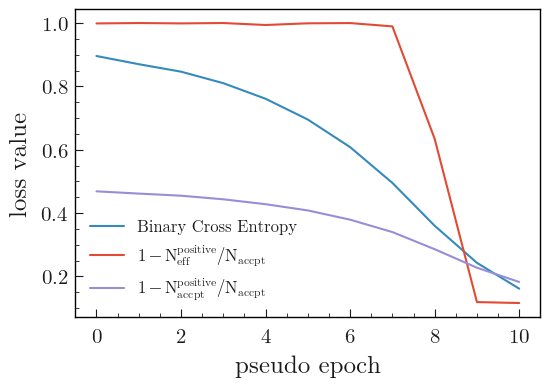

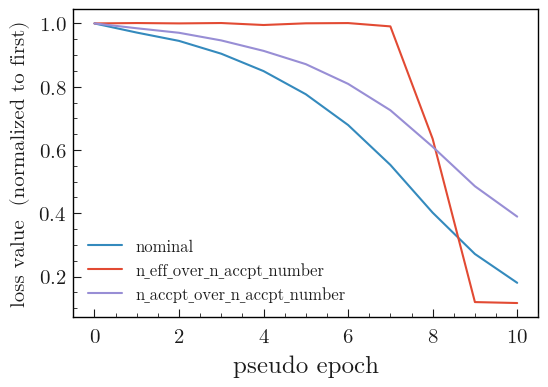

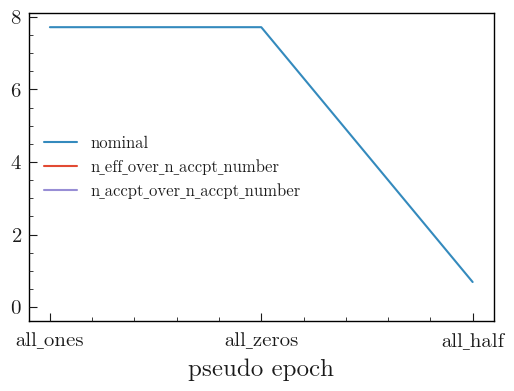

In [6]:
"""
    Visualize how the different loss functions evolve 
    as a function of the seperation between the two classes
    
"""



res = {k:[] for k in losses}


for loss_name, loss_func in losses.items():
    print(loss_name)
    #for scale in scales:
    for pred_name in pred_names+pred_names_same:
        loss_val = loss_func(df['truth'], df[pred_name] )
        res[loss_name].append(loss_val)        


fig, ax = plt.subplots()
for loss_name, vals  in res.items():
    loss_label = models_info[loss_name].get('label', loss_name)
    ax.plot(vals[:len(pred_names)], label=loss_label)


ax.legend()
ax.set_xlabel("pseudo epoch")
ax.set_ylabel("loss value")

fig, ax = plt.subplots()
for loss_name, vals  in res.items():
    ax.plot(vals[:len(pred_names)]/vals[0], label=loss_name)


ax.legend()
ax.set_xlabel("pseudo epoch")
ax.set_ylabel("loss value  (normalized to first)", fontsize=15)
# how do I make the y label font size smaller?
#ax.set_yticklabels(ax.get_yticks(), fontsize=8)



fig, ax = plt.subplots()
for loss_name, vals  in res.items():
    ax.plot( pred_names_same, vals[len(pred_names):], label=loss_name)

ax.legend()
ax.set_xlabel("pseudo epoch")
#ax.set_ylabel("loss value  (normalized to first)")

In [32]:
res['n_eff_over_n_accpt_number']

[<tf.Tensor: shape=(), dtype=float64, numpy=0.9999964659058362>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9998705125386442>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9999916724137513>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9999898419775077>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.999975093975775>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9999476603992499>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9999848047822446>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9998981793214279>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9970093950643849>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9829200589399648>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9786988395472538>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9955323897697388>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-inf>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9910647795394775>]

In [4]:
res.keys()
res['n_eff_over_n_accpt_number']


#pred_names
#pred_names
# df[pred_names[0]]

for pred_name in pred_names:
    
    pred = df[pred_name]
    n_accepted = np.sum(pred)

    y_pred_pos = pred[df.truth==1]    
    n_eff_pos = tf_effective_number(y_pred_pos)
    n_eff = tf_effective_number(pred)


    truth = df.truth
    loss = losses['n_eff_over_n_accpt_number'](truth, pred)
    print(f"{pred_name:<30}: {loss = :<20} {n_accepted =  :<20} {n_eff_pos = :<20} {n_eff = :<20} ")

NameError: name 'res' is not defined

,index,length,y,azimuth,majorID,pdg_encoding,zenith,minorID,interaction_height,energy,...,pred0.64,pred0.55,pred0.45999999999999996,pred0.37,pred0.28,pred0.19000000000000006,pred0.1,all_ones,all_zeros,all_half
0,11408,95907.809059,-3151.044503,3.283230,1.224837e+19,2.212000e+03,0.217204,2227605.0,19145.57750,3.359995e+03,...,0.783381,0.239139,0.254064,0.402817,0.044721,0.294440,0.339537,1.0,0.0,0.5
1,8748,95030.700206,9610.020998,2.947376,1.771279e+19,1.000020e+09,0.413672,208665.0,25785.37000,5.104588e+03,...,0.157097,0.936905,0.735345,0.660248,0.318540,0.107631,0.107988,1.0,0.0,0.5
2,1865,137684.219943,-102703.107246,5.294704,1.527382e+19,1.000070e+09,0.836314,204791.0,20523.57250,1.868129e+07,...,0.645924,0.227530,0.783426,0.461560,0.816260,0.650779,0.981678,1.0,0.0,0.5
3,188,138344.028895,113156.502653,1.902131,6.525154e+18,1.000020e+09,0.822108,611584.0,18632.48750,4.532584e+06,...,0.548408,0.803338,0.736889,0.711420,0.654110,0.569526,0.991864,1.0,0.0,0.5
4,3057,106322.483535,-52711.564207,5.156986,8.832488e+18,2.212000e+03,0.478745,110618.0,18430.65000,3.895022e+04,...,0.507510,0.688177,0.787285,0.730838,0.887869,0.924097,0.951090,1.0,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16329,6595,131032.499707,-91308.354077,5.124886,6.336043e+16,2.212000e+03,0.726630,639554.0,14863.67125,2.162278e+05,...,0.059099,0.211010,0.402303,0.292385,0.345016,0.639694,0.053964,1.0,0.0,0.5
16330,8506,179769.056051,75194.550237,0.411679,1.034910e+19,2.212000e+03,1.042416,1903487.0,22171.92500,2.169582e+07,...,0.289364,0.066389,0.259897,0.727586,0.548170,0.078923,0.354162,1.0,0.0,0.5
16331,10522,123154.163277,113033.529561,0.921389,1.004297e+19,1.000070e+09,0.911883,91584.0,37397.96000,1.452675e+07,...,0.363704,0.589343,0.978368,0.981492,0.767375,0.872350,0.907085,1.0,0.0,0.5
16332,13625,192175.350341,212916.565904,1.082937,1.528583e+19,1.000130e+09,1.148738,105341.0,34077.74250,8.579025e+06,...,0.436851,0.122617,0.544346,0.917742,0.890623,0.832239,0.969312,1.0,0.0,0.5


In [24]:

pred_name = pred_names[-1]

pred = df[pred_name] 
n_accpt = np.sum(pred)


print(f"""
{n_accpt = }
""")




n_accpt = 9208.477877623976



In [13]:
df['truth'].value_counts()

truth
True     8182
False    8152
Name: count, dtype: int64

nominal
n_eff
n_eff_pos


Text(0.5, 0, 'pseudo epoch')

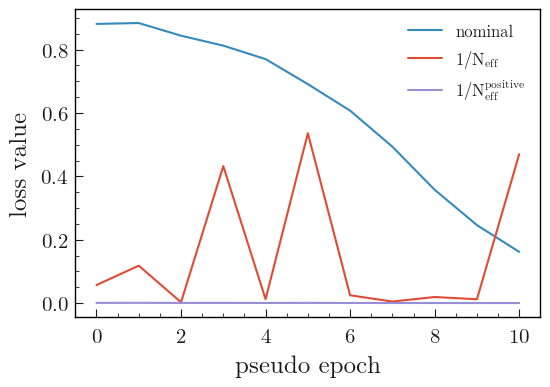

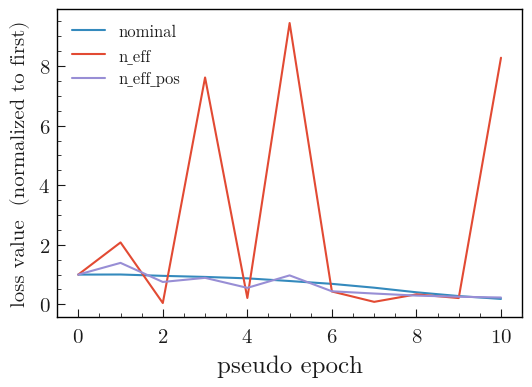

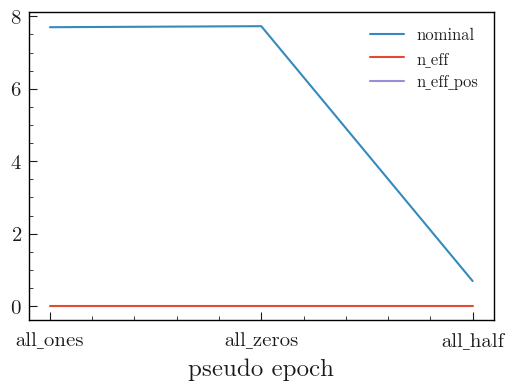

In [13]:
#df[pred_names].apply( lambda x: 1.0/tf_effective_number(x) )

# df[pred_names].apply( lambda x: tf.reduce_sum(x) )

#df[pred_names].apply( lambda x: tf_effective_number(x) )

np.sum(df[pred_names[-1]])

9212.307368268255

pred1.0 3798.1107446517035
pred0.9526315789473684 3688.3657159060945
pred0.9052631578947369 2435.565092842752
pred0.8578947368421053 2847.878648760422
pred0.8105263157894737 3628.4780130657773
pred0.763157894736842 3511.2895456418264
pred0.7157894736842105 3478.4724239481134
pred0.6684210526315789 3465.8470946303714
pred0.6210526315789473 4375.11276010683
pred0.5736842105263158 3151.248117365164
pred0.5263157894736842 3449.6246882322157
pred0.47894736842105257 3618.127800380156
pred0.43157894736842106 3204.4999906988696
pred0.38421052631578945 4335.890493270856
pred0.33684210526315783 3836.4405528421594
pred0.2894736842105263 2650.378968614171
pred0.2421052631578947 4459.483508282603
pred0.1947368421052631 4270.059094077205
pred0.1473684210526316 4336.412758582167
pred0.1 3783.2964080000606


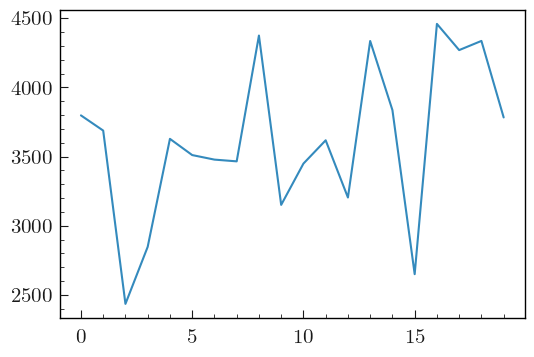

In [18]:
neffs = []
for pred_name in pred_names:
    #pred_name = pred_names[-1]
    y_pred = df[pred_name]
    truth = df['truth']

    #tf_effective_number??

    def get_sample_mask_from_pred(y_pred):
        return np.random.random(size=len(y_pred)) < y_pred

    sample_mask = get_sample_mask_from_pred(y_pred)

    w = 1/y_pred[sample_mask]
    n_eff = np.sum(w)**2/np.sum(w**2)
    print(pred_name, n_eff)
    neffs.append(n_eff)


plt.plot(neffs)

In [15]:
sample_kwargs = dict(frac=1)
sample_kwargs = dict(n=10_000)

#del df_train

try:
    df_train
except NameError:
    df_train = mf.df_train.sample(**sample_kwargs)
    del mf._df_train
    
    df_test = mf.df_test.sample(**sample_kwargs)
    del mf._df_test

label = mf.labels[0]
df_train['truth'] = df_train[label]
df_test['truth'] = df_test[label]

mf.df_train_sample = df_train
mf.df_test_sample = df_test

loading only 1 out of 1...
loading DF: ['/data/user/navidkrad/hdf/cascades_v0.1_L3/sim/IceCube/2020/CORSIKA-in-ice/20904/0000000-0000999/combined_preproc_presel_hasphotons_balanced_by_Level3/combined_preproc_presel_hasphotons_balanced_by_Level3_0000000-0000999.hdf5']:
       ['/data/user/navidkrad/hdf/cascades_v0.1_L3/sim/IceCube/2020/CORSIKA-in-ice/20904/0000000-0000999/combined_preproc_presel_hasphotons_balanced_by_Level3/combined_preproc_presel_hasphotons_balanced_by_Level3_0000000-0000999.hdf5']


In [14]:
"""  
    Training using different loss functions
"""
# models_info = {
#         #'f1score':dict(loss=f1score),
#         #'n_eff_over_n_accpt_number': dict(loss=tf_loss_n_eff_over_n_accpt),
#         #'n_accepted_over_n_sim': dict(loss=tf_loss_n_passed_over_n_accept),
    
#         'n_eff_over_n_accpt_number': dict(loss=tf_loss_n_eff_over_n_accept),
#         'n_accpt_over_n_accpt_number': dict(loss=tf_loss_n_accpetpos_over_n_accept),

#         'nominal': dict(),
# }

f1score = tf.keras.metrics.F1Score(average="weighted", threshold=0.5)
default_kwargs = dict(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

models = {}

mf.weights = None





for model_name, model_info in models_info.items():
    label = model_info.pop('label', model_name)
    mf.plot_dir = f'/data/user/navidkrad/plots/{mf.version_tag}/models/inv_n_eff_loss/{model_name}'
    os.makedirs(mf.plot_dir, exist_ok=True)
    mf.define_model()
    model_kwargs = dict(**default_kwargs)
    model_kwargs.update(**model_info)
    mf.compile_model(**model_kwargs)
    mf.fit(xy=None,
                    # xy=(df_train[mf.features], 
                    # df_train['truth']), 
                    n_epoch=2, 
                    batch_size=mf.batch_size,
                    #sample_weight=None,
                    callbacks=[EpochVariableUpdater()],
                    )


    mf.df_train_sample[model_name] = mf.model.predict(mf.df_train_sample[mf.features], batch_size=mf.batch_size)
    mf.df_test_sample[model_name] = mf.model.predict(mf.df_test_sample[mf.features], batch_size=mf.batch_size)
    mf.plot_predictions(variable=model_name)
    #mf.plot_history()
    models[model_name] = mf.model

    #mf.plot_predictions(variable=model_name)
    #mf.plot_history()
    mf.generate_html()


model_kwargs = {'init_layer': 192, 'final_layer': 4, 'layer_repeat': 3, 'unit_step': 4, 'dropout': 0.8, 'hidden_activation': 'tanh', 'max_layers': 30}
optimizer_kwargs = {'learning_rate': <keras.src.optimizers.schedules.learning_rate_schedule.InverseTimeDecay object at 0x7f12f1e37d50>, 'ema_momentum': 0.999, 'clipnorm': 1.0, 'weight_decay': 0.0005, 'ema_overwrite_frequency': True}
========== optimizer = <keras.src.optimizers.adam.Adam object at 0x7f129846ee90>
compile_kwargs = {'weighted_metrics': ['accuracy']}
Epoch 1/2


reading 39 files
     39/Unknown - 11s 198ms/step - loss: 0.0024 - accuracy: 0.9282reading 9 files
DEBUG 0 <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>
39/39 [==============================] - 16s 325ms/step - loss: 0.0024 - accuracy: 0.9282 - val_loss: 0.0189 - val_accuracy: 0.2245
Epoch 2/2
reading 39 files
39/39 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9400reading 9 files
DEBUG 1 <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2>
39/39 [==============================] - 5s 123ms/step - loss: 0.0019 - accuracy: 0.9400 - val_loss: 0.0130 - val_accuracy: 0.4354


AttributeError: 'ModelFactory' object has no attribute 'df_train_sample'

In [37]:
model_info

{'label': 'Binary Cross Entropy'}

In [78]:

# epoch_var

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>

In [81]:
epoch_var

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>

In [ ]:
mf.df_train_sample['pred']

3390222    0.513654
2747032    0.509675
2315268    0.508884
2919586    0.509288
2682600    0.509161
             ...   
357990     0.509245
3135681    0.509970
2927545    0.508854
1109024    0.510037
1335476    0.510260
Name: pred, Length: 500000, dtype: float32

In [ ]:
# mf.plot_history()

In [ ]:
#f1score(df['truth'], df[pred_name] )
#df[pred_name]
f1score = tf.keras.metrics.F1Score(threshold=0.5)
f1score(df['truth'], df['truth'])

ValueError: FBetaScore expects 2D inputs with shape (batch_size, output_dim). Received input shapes: y_pred.shape=(100000,) and y_true.shape=(100000,).